In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sc
import pandas as pd
from functools import reduce

In [52]:
def max3(arr):
    first = max(arr[0], arr[1])
    second = min(arr[0], arr[1])
    third = -1e+10
    for i in range(2, len(arr)):
        if arr[i] > first:
            third = second
            second = first
            first = arr[i]
        elif arr[i] > second:
            third = second
            second = arr[i]
        elif arr[i] > third:
            third = arr[i]
    return third

In [53]:
def num5(i):
    i = str(i)
    return '0' * (5 - len(i)) + i 

Данные о шумах

In [54]:
df = pd.read_csv('training2017/REFERENCE-original.csv', header=-1,
                 sep=',', 
                 encoding='latin1',
                )

In [56]:
ECG = list('OAN')
noises = list()
for i in range(len(df)):
    if df[1][i] not in ECG:
        noises.append(df[0][i])

Описание модели

In [57]:
mat = sc.loadmat('training2017/A00001.mat')['val'][0]

Если мы имеем дело с сигналом ЭКГ, то наша задача найти 2 похожик (проще всего подряд идущих) участка одинаковой длины. Мерой их похожести является коэффмцмент корелляции, который должен быть положительным и достаточно большим. Мы будем искать по 3 похожих участка, так как по 1 участку мы можем найти и у выбросов

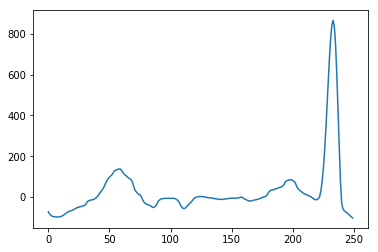

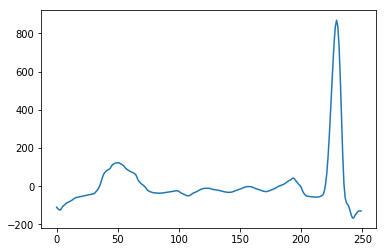

In [58]:
plt.plot(range(len(mat[3200:3450])), mat[3200:3450])
plt.show()
plt.plot(range(len(mat[3450:3700])), mat[3450:3700])
plt.show()

In [59]:
data1 = mat[3200:3450]
data2 = mat[3450:3700]

In [60]:
ro = np.corrcoef(data1, data2)

In [61]:
ro[0, 1]

0.6977951086398307

И таким образом нашей задачей будет найти такие корелляции, и если они будут достаточно большими, мы будем принимать данные как экг, в противном случает отвергать. Из посчитанных корелляций будем брать третий максимум, так как предполагаем, что у ЭКГ похожих подряд идущий участков должно быть много, а у шума нет

In [62]:
def correlation(mat, step):
    ex = int(len(mat)/5)
    if step != 4:
        X = np.mean(list(mat[0:step * ex]) + list(mat[(step + 1) * ex:]))
        V = np.var(list(mat[0:step * ex]) + list(mat[(step + 1) * ex:]))
    else:
        X = np.mean(mat[4 * ex:])
        V = np.var(mat[4 * ex])
    high = X + 1.96 * np.sqrt(V)
    low = X - 1.96 * np.sqrt(V)
    #print(high, low)
    count1 = 0
    count2 = 0
    highs = list()
    lows = list()
    for i in range(1, len(mat) - 1):
        if mat[i - 1] > high and mat[i + 1] > high and mat[i] >= mat[i - 1] and mat[i] >= mat[i + 1]:
            count1 += 1
            highs.append(i)
        elif mat[i] < low and mat[i] <= mat[i - 1] and mat[i] <= mat[i + 1]:
            count2 += 1
            lows.append(i)
    ros = list()
    for i in range(1, len(highs) - 3):
        l1 = highs[i + 1] - highs[i - 1]
        l2 = highs[i + 3] - highs[i + 1]
        delt = min(l1, l2)
        if delt > 200:
            ro = np.corrcoef(mat[highs[i + 1] - delt:highs[i + 1]], mat[highs[i + 3] - delt:highs[i + 3]])
            ros.append(ro[0, 1])
    #print(lows)
    rosx = list()
    for i in range(1, len(lows) - 3):
        l1 = lows[i + 1] - lows[i - 1]
        l2 = lows[i + 3] - lows[i + 1]
        delt = min(l1, l2)
        if delt > 200:
            ro = np.corrcoef(mat[lows[i + 1] - delt:lows[i + 1]], mat[lows[i + 3] - delt:lows[i + 3]])
            rosx.append(ro[0, 1])
    if len(ros) > 3 and len(rosx) > 3:
        return(max(max3(ros), max3(rosx)))
    elif len(ros) > 3:
        return max3(ros)
    elif len(rosx) > 3:
        return max3(rosx)
    return 0

Вычисляем значения для всех данных

In [63]:
correlations = list()
it = 1
flag = 1
while flag:
    try:
        if 'A' + num5(it) + '.mat' not in noises:
            mat = sc.loadmat('training2017/A' + num5(it) + '.mat')['val'][0]
            cv = list()
            for j in range(4):
                cv.append(correlation(mat, j))
            correlations.append(max(cv))
            #if it % 100 == 0:
            #    print(it)
            it += 1
    except:
        flag = 0
        print('EOF')

EOF


Теперь только для шумов

In [64]:
coors = list()
for i in noises:
    mat = sc.loadmat('training2017/' + i + '.mat')['val'][0]
    cv = list()
    for j in range(4):
        #print(i)
        cv.append(correlation(mat, j))
    coors.append(max(cv))
    #print(i)

correlations - массив для всех данных, coors - только для шумов

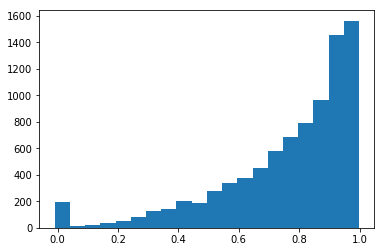

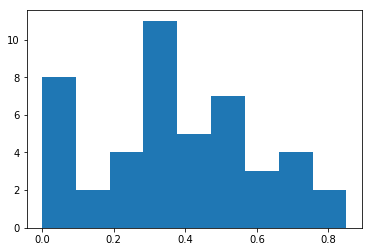

In [65]:
plt.hist(correlations, 20)
plt.show()
plt.hist(coors, 9)
plt.show()

Имеет смысл принимать за экг все данные, у которых посчитанное значение > 0.5

Всего определены как шум

In [66]:
sum(list(map(lambda x: x <= 0.5, correlations)))

1072

Из них реально шум

In [67]:
sum(list(map(lambda x: x <= 0.5, coors)))

33

A00205


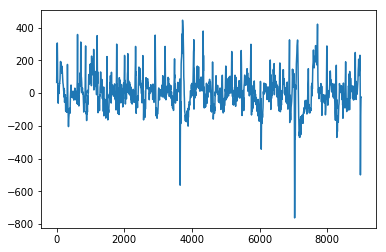

A00585


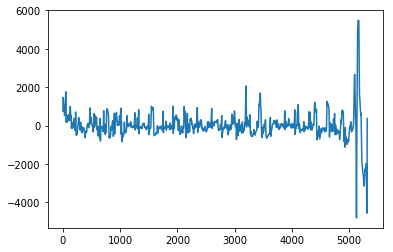

A01006


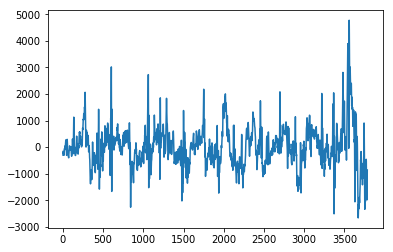

A01070


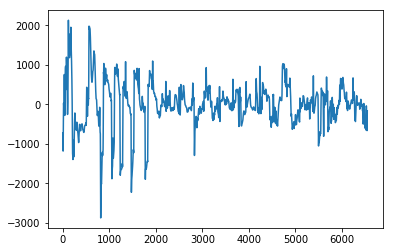

A01246


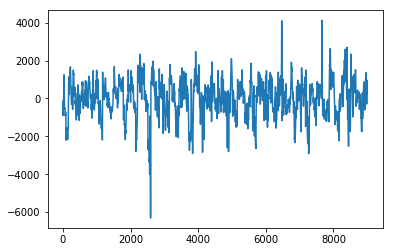

A01521


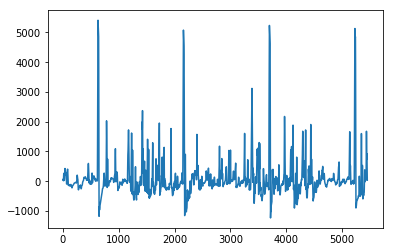

A01567


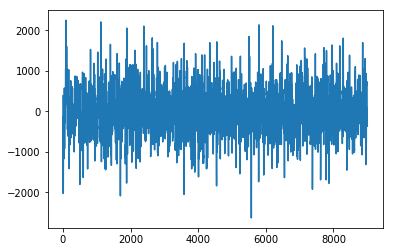

A01707


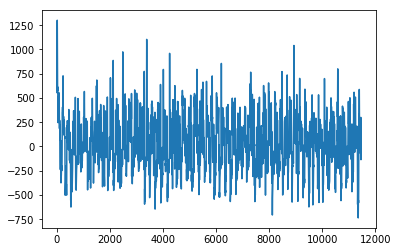

A01727


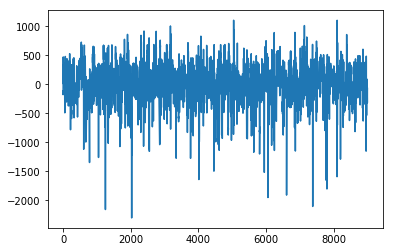

A02168


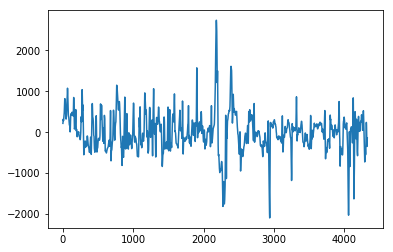

A02372


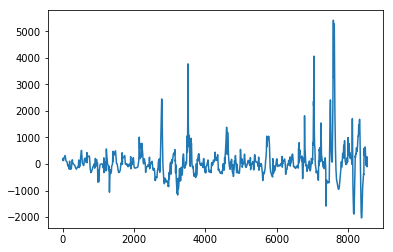

A02772


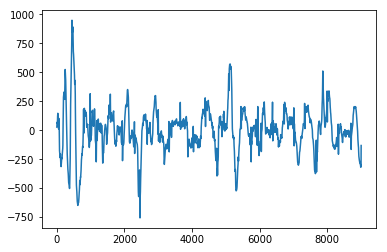

A02833


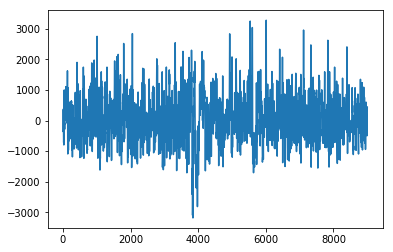

A03549


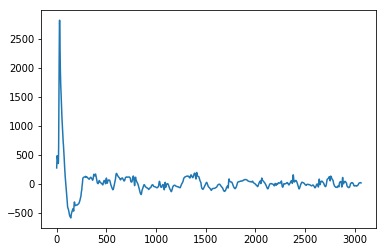

A04086


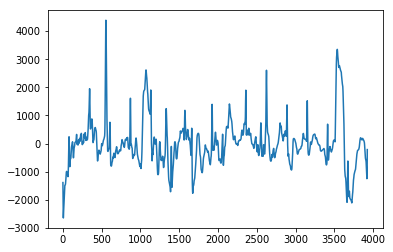

A04137


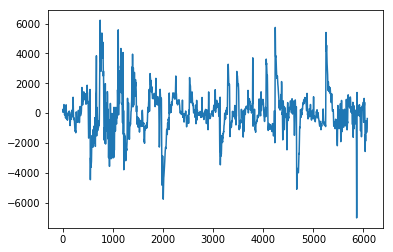

A04170


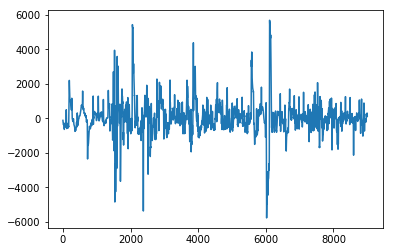

A04186


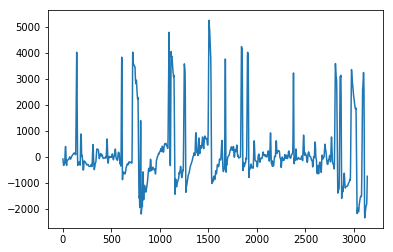

A04216


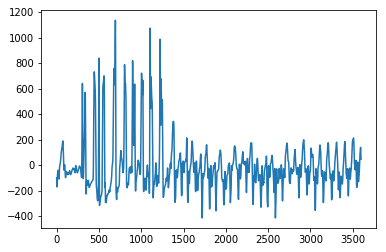

A04452


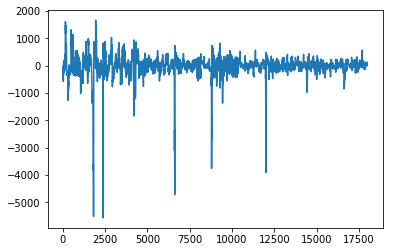

A04522


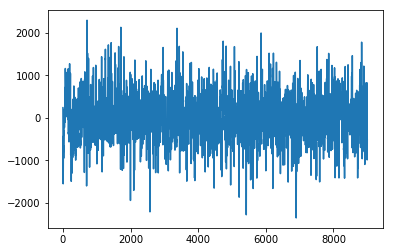

A04701


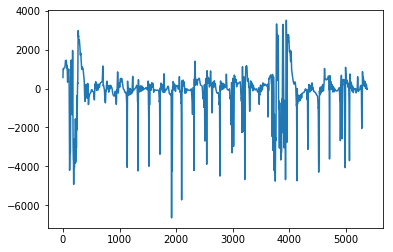

A04805


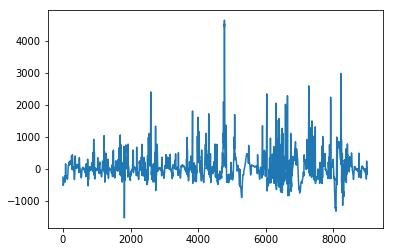

A04948


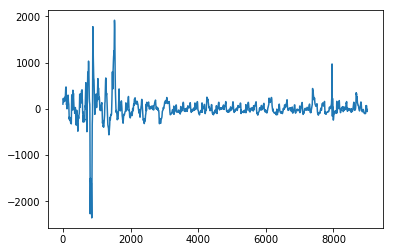

A05365


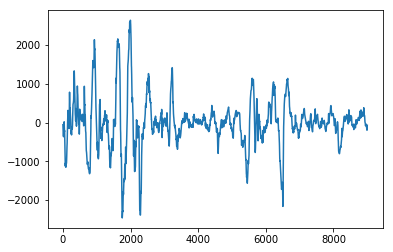

A06435


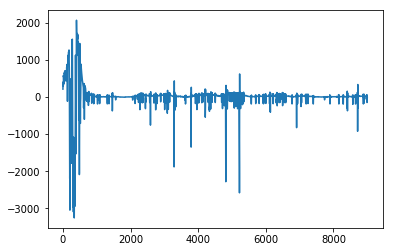

A07138


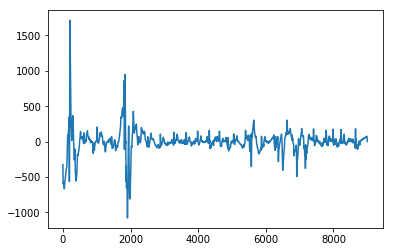

A07139


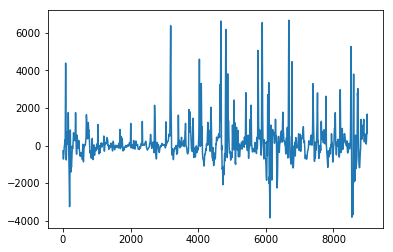

A07320


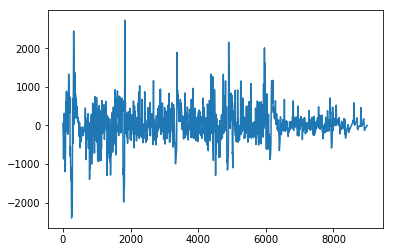

A07322


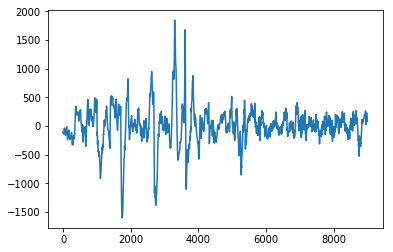

A07727


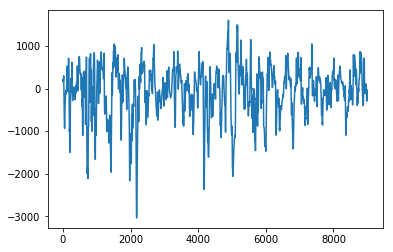

A08021


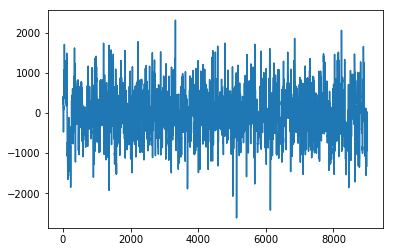

A08160


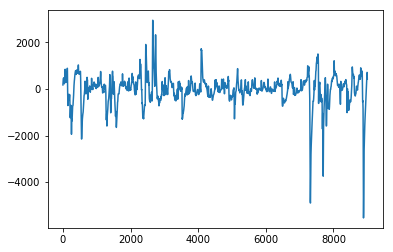

In [68]:
for i in range(len(coors)):
    if coors[i] <= 0.5:
        print(noises[i])
        mat = sc.loadmat('training2017/' + noises[i] + '.mat')['val'][0]
        plt.plot(range(len(mat)), mat)
        plt.show()